<div align="center" style='font-size: 21px; margin: 21px'><u><b>Классификация удовлетворённости пассажира</b><u></div>
 <div align="right" style='width: 333px; margin-left: auto; margin-bottom: 21px'><u><b>* Построение модели для классификации удовлетворённости пассажира </b><u></div>
        

<!-- <a id="ref3"></a> 
 -->
<div style="background-color: #BDDBF9; margin-top: 8px; padding: 22px; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px;">
    <p style='font-size: 21px'>Содержание</p>
    <ol>
        <li><a style='' href="#ref1">Описание данных</a></li>
        <li><a style='' href="#ref2">Импорт данных и подготовка</a></li>
        <li><a style='' href="#ref3">Изучение данных</a></li>
        <li><a style='' href="#ref4">Очистка данных</a></li>
        <li><a style='' href="#ref5">Визуализация данных</a></li>
        <li><a style='' href="#ref7">Создание модели</a></li> 
        <li><a style='' href="#ref8">Заключение</a></li>
    </ol>
</div>

<a id="ref1"></a> 
Имеется информация об удовлетворенности клиентов сервисами авиакомпании. 

Предварительно обработав данные, построим несколько вариантов прогнозных моделей, предсказывающих факт удовлетворенности / не удовлетворенности клиентов.

Оценим качество каждой из моделей и выберем наиболее точную.


<a id="ref2"></a> 
### Импорт библиотек, создание функций

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score#plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline
import time
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
from sklearn import metrics

/var/folders/9_/ll5ms3kn1cvgh7ng385rxvq40000gn/T/ipykernel_20158/4224254715.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


This script was made to run only on Google Colab notebooks, other environments was not tested completely
You are not in Colab envirement, make sure you already have Plotly > 4.9.0 and kaleido


In [3]:
def cf_matrix_plot(y_test, X_test, model):
    """Матрица путаницы"""
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='RdYlBu')

    ax.set_title('Матрица путаницы\n\n');
    ax.set_xlabel('\nПредсказания')
    ax.set_ylabel('Фактические значения');
    ax.xaxis.set_ticklabels(['Ложь','Истина'])
    ax.yaxis.set_ticklabels(['Ложь','Истина'])
    return plt.show()

In [4]:
def roc_auc(model,  roc_auc, X_test, y_test):
    """Нахождение площади под кривой ошибок, построение графика"""
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    fig = px.area(
        x=fpr, y=tpr,
        labels=dict(x='Ложноположительная доля', y='Истинно положительная доля'),
        width=700, height=500
    )
    fig.update_layout(
    title=f'{model} - площадь под ROC-кривой={roc_auc:.4f})',
    title_x=0.5   
    )
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show('png')

In [5]:
def model_create(model, X_train, y_train, X_test, y_test):
    """Обучение модели, оценка точности модель"""
    intial_time=time.time()
    model.fit(X_train,y_train.ravel())
        
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Точность прогноза = {}".format(accuracy))
    roc_auc = metrics. roc_auc_score (y_test, y_pred)
    print("AUC ROC - Площадь под кривой ошибок = {}".format(roc_auc))
    
    time_taken = time.time()-intial_time
    print("Затраченное время = {}".format(time_taken))
    
    print(classification_report(y_test,y_pred,digits=5))
    cf_matrix_plot(y_test, X_test, model) 
    return model, accuracy, roc_auc, time_taken

In [6]:
def age(agevalue):
    """Категория возраста"""
    if agevalue < 40:
        return 1
    elif agevalue < 60:
        return 2
    else:
        return 3

In [7]:
def show_missing(df):
    """Возвращает df - тип, количество, кол.уникальных, NaN и % NaN"""
    
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    pc_missing = []
    
    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())
        pc_missing.append(round((df[item].isna().sum() / len(df[item])) * 100, 2))

    output = pd.DataFrame({
        'Колонка': variables, 
        'Тип значений': dtypes,
        'Количество значений': count,
        'Кол.уникальные значения': unique,
        'Кол.NaN': missing, 
        '% NaN': pc_missing
    })    
        
    return output

<br>

### Чтение и подготовка данных 

In [8]:
df = pd.read_csv("Airline_Passenger_Satisfaction.csv", usecols=range(1,25))

In [9]:
pd.set_option('display.max_columns', None)
df.sample(4)

,ID,Пол,Возраст,Тип клиента,Тип путешествия,Класс,Дальность полёта,Задержка вылета,Задержка прибытия,Удобство времени вылета и прибытия,Простота онлайн бронирования,Услуга регистрации заезда,Онлайн-посадка,Расположение ворот,Обслуживание на борту,Комфорт сидения,Обслуживание в номерах для ног,Чистоплотность,Еда и напитки,Обслуживание понимаете,Услуга wi-fi в полёте,Развлечения на борту,Обработка багажа,Удовлетворённость
93974,93975,Мужчина,62,Возвращаемый,Бизнес,Бизнес класс,1218,47,34.0,3,3,4,5,3,5,5,5,4,4,5,3,5,5,Неудовлетворённый
48664,48665,Мужчина,45,Возвращаемый,Бизнес,Бизнес класс,250,0,0.0,4,4,3,4,4,4,5,4,5,2,4,4,4,4,Неудовлетворённый
69807,69808,Женщина,58,Возвращаемый,Бизнес,Бизнес класс,2354,0,0.0,4,5,4,4,4,5,5,5,4,3,5,4,5,5,Неудовлетворённый
73946,73947,Мужчина,38,Возвращаемый,Бизнес,Бизнес класс,3893,11,0.0,3,3,5,2,3,4,2,4,3,4,4,3,4,4,Неудовлетворённый


###  Преобразуем именно столбцов в формат camelCase

In [10]:
df = df.rename(columns = {'Пол': 'gender',
                              'Возраст': 'age', 
                              'Тип клиента': 'customerType', 
                              'Тип путешествия': 'typeOfTravel', 
                              'Класс': 'class',
                              'Дальность полёта': 'flightDistance', 
                              'Задержка вылета': 'departureDelay', 
                              'Задержка прибытия': 'arrivalDelay',
                              'Удобство времени вылета и прибытия': 'departureAndArrivalTimeConvenience', 
                              'Простота онлайн бронирования': 'easeOfOnlineBooking',
                              'Услуга регистрации заезда': 'checkInService', 
                              'Онлайн-посадка': 'onlineBoarding', 
                             'Расположение ворот': 'gateLocation',
                              'Обслуживание на борту': 'onBoardService', 
                              'Комфорт сидения': 'seatComfort', 
                              'Обслуживание в номерах для ног': 'legRoomService', 
                              'Чистоплотность': 'cleanliness',
                              'Еда и напитки': 'foodAndDrink', 
                              'Обслуживание понимаете': 'inflightService', 
                              'Услуга wi-fi в полёте': 'inFlightWifiService',
                              'Развлечения на борту': 'inflightEntertainment',
                              'Обработка багажа': 'baggageHandling', 
                              'Удовлетворённость': 'satisfaction'})

In [11]:
display(df.sample(2))

,ID,gender,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
94308,94309,Женщина,49,Возвращаемый,Бизнес,Бизнес класс,3263,0,0.0,1,1,4,4,1,4,4,4,4,5,4,1,4,4,Неудовлетворённый
118842,118843,Женщина,29,Первый раз,Бизнес,Эконом плюс,338,0,0.0,2,2,2,2,4,4,1,4,1,1,4,2,1,4,Удовлетворённый


<br><a id="ref3"></a> 
### Изучение данных 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ID                                  129880 non-null  int64  
 1   gender                              129880 non-null  object 
 2   age                                 129880 non-null  int64  
 3   customerType                        129880 non-null  object 
 4   typeOfTravel                        129880 non-null  object 
 5   class                               129880 non-null  object 
 6   flightDistance                      129880 non-null  int64  
 7   departureDelay                      129880 non-null  int64  
 8   arrivalDelay                        129487 non-null  float64
 9   departureAndArrivalTimeConvenience  129880 non-null  int64  
 10  easeOfOnlineBooking                 129880 non-null  int64  
 11  checkInService            

In [13]:
df.dtypes

ID                                      int64
gender                                 object
age                                     int64
customerType                           object
typeOfTravel                           object
class                                  object
flightDistance                          int64
departureDelay                          int64
arrivalDelay                          float64
departureAndArrivalTimeConvenience      int64
easeOfOnlineBooking                     int64
checkInService                          int64
onlineBoarding                          int64
gateLocation                            int64
onBoardService                          int64
seatComfort                             int64
legRoomService                          int64
cleanliness                             int64
foodAndDrink                            int64
inflightService                         int64
inFlightWifiService                     int64
inflightEntertainment             

In [14]:
# Получим колонки, с которыми будем работать 
df.columns

Index(['ID', 'gender', 'age', 'customerType', 'typeOfTravel', 'class',
       'flightDistance', 'departureDelay', 'arrivalDelay',
       'departureAndArrivalTimeConvenience', 'easeOfOnlineBooking',
       'checkInService', 'onlineBoarding', 'gateLocation', 'onBoardService',
       'seatComfort', 'legRoomService', 'cleanliness', 'foodAndDrink',
       'inflightService', 'inFlightWifiService', 'inflightEntertainment',
       'baggageHandling', 'satisfaction'],
      dtype='object')

> краткий обзор, что содержит данные 

In [15]:
# Создаем df-обзор колонок
df_about = show_missing(df)

In [16]:
# Переворачиваем таблицу
df_about = df_about.transpose().rename(columns=df_about.transpose().iloc[0]).iloc[1:,:]

In [17]:
df_about

,ID,gender,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
Тип значений,int64,object,int64,object,object,object,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object
Количество значений,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880
Кол.уникальные значения,129880,2,75,2,2,3,3821,466,473,6,6,6,6,6,6,6,6,6,6,6,6,6,5,2
Кол.NaN,0,0,0,0,0,0,0,0,393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
% NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Уникальные значения каждого столбца
df_about.iloc[[2]]

,ID,gender,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
Кол.уникальные значения,129880,2,75,2,2,3,3821,466,473,6,6,6,6,6,6,6,6,6,6,6,6,6,5,2


In [19]:
print("Количество пассажиров:      ", df.shape[0])
print("Количество атрибутов таблици: ",df.shape[1])

Количество пассажиров:       129880
Количество атрибутов таблици:  24


<a id="ref4"></a> 
<br>
## Очистка данных 
Избавимся от 
* Дубликатов
* Нулевых значений

#### Заполнение пропусков столбца "Задержка прибытия" средним значением 

In [20]:
df.arrivalDelay = df.arrivalDelay.fillna(df.arrivalDelay.mean())

In [21]:
print('Количество нулевых значений :',df.isna().sum().sum())

Количество нулевых значений : 0


In [22]:
print('Количество дубликатов :',df.duplicated().sum())

Количество дубликатов : 0


##### Теперь наши данные готовы к изучению, визуализации и, наконец, к прогнозированию.

### Получим уникальные значения определённых столбцов 

In [23]:
list_unique = ['gender', 'customerType', 'class', 'satisfaction', 'typeOfTravel']

dict_unique = {}

In [24]:
print('УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦОВ:')
for (index, i) in enumerate(list_unique): 
    print(i, ' - ',  df[f'{i}'].unique())

УНИКАЛЬНЫЕ ЗНАЧЕНИЯ СТОЛБЦОВ:
gender  -  ['Мужчина' 'Женщина']
customerType  -  ['Первый раз' 'Возвращаемый']
class  -  ['Бизнес класс' 'Эконом класс' 'Эконом плюс']
satisfaction  -  ['Удовлетворённый' 'Неудовлетворённый']
typeOfTravel  -  ['Бизнес' 'Личный']


<br><a id="ref5"></a> 
### Визуализация данных

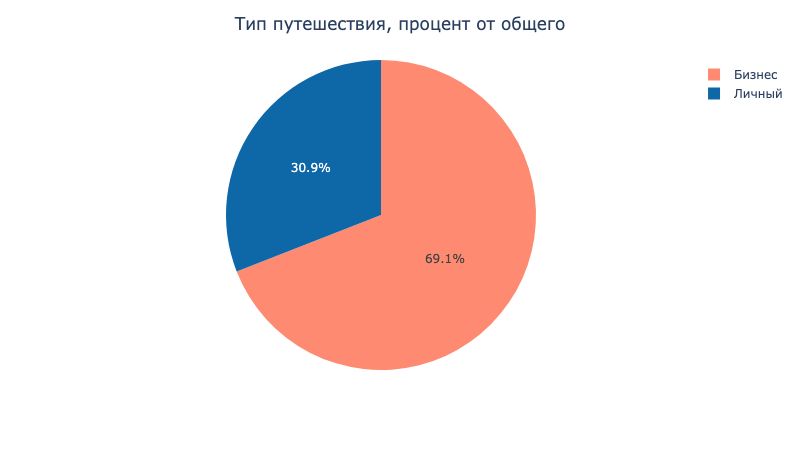

In [25]:
fig = px.pie(df, names = df['typeOfTravel'].value_counts().keys(),
                 values = df['typeOfTravel'].value_counts().values, width=100, height=100,
                 color_discrete_sequence=['#FE8A71', '#0E67A7', '#3DA4AB'])
fig.update_layout(
title='Тип путешествия, процент от общего',
title_x=0.5)
gitly.show(fig)

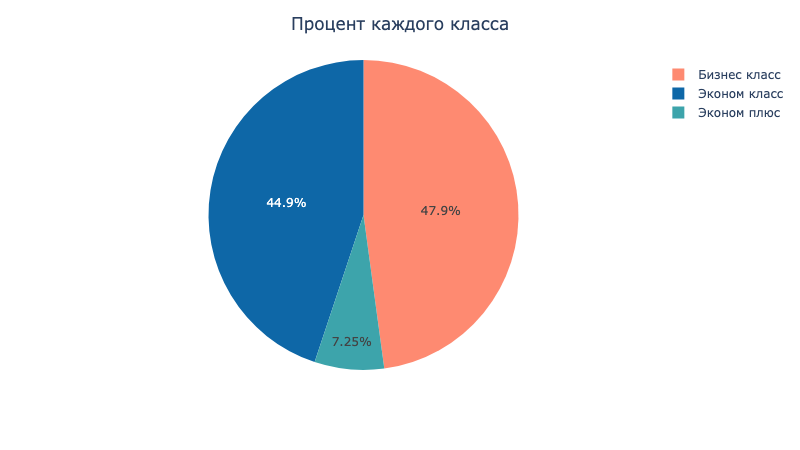

In [26]:
fig = px.pie(df, names = df['class'].value_counts().keys(),
                 values = df['class'].value_counts().values, width=100, height=100,
                 color_discrete_sequence=['#FE8A71', '#0E67A7', '#3DA4AB'])
fig.update_layout(
title='Процент каждого класса',
title_x=0.5)
gitly.show( fig )

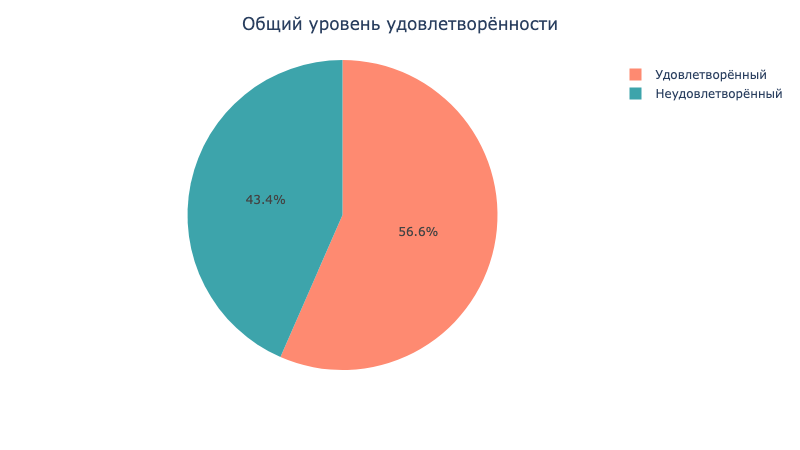

In [27]:
fig = px.pie(df, names = df['satisfaction'].value_counts().keys(),
                 values = df['satisfaction'].value_counts().values, width=100, height=100,
                 color_discrete_sequence=['#FE8A71', '#3DA4AB', '#0E67A7'])
fig.update_layout(
title='Общий уровень удовлетворённости',
title_x=0.5)
gitly.show( fig )

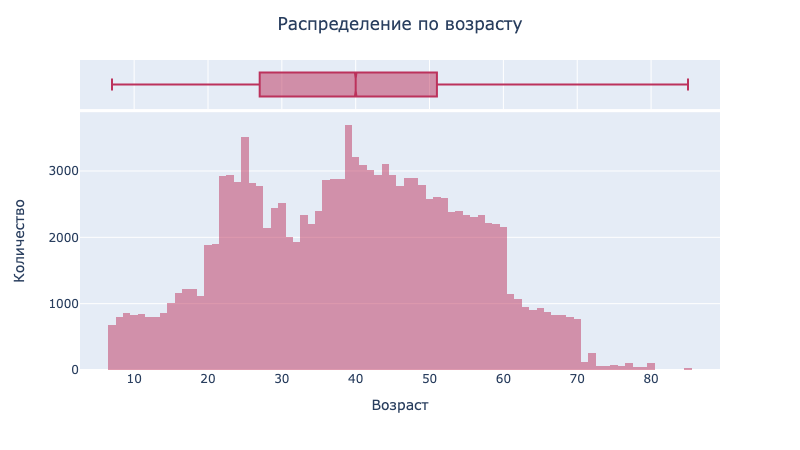

In [28]:
fig = px.histogram(df, x = 'age',  marginal ='box', barmode = 'overlay',
                 color_discrete_sequence=['#BC325C'])
fig.update_layout(
    title='Распределение по возрасту',
    xaxis_title="Возраст",
    yaxis_title="Количество",
    title_x=0.5
)
gitly.show( fig )

* Уровень удовлетворенности более 50%.
* По данным пассажиров, в классе путешествий преобладают бизнес-класс (48%) и эконом класс (45%), а остальные — эконом-плюс (7%).
* Возрастные выбросы не так значительны

In [29]:
list_plot = ['gender', 'customerType', 'class']
xaxis_title = ['Пол', 'Тип клиента', 'Класс']

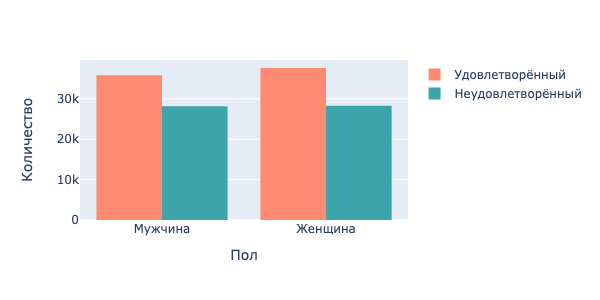

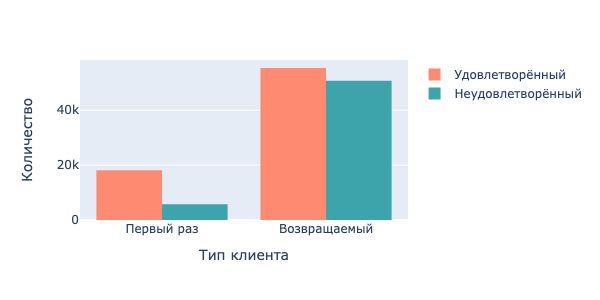

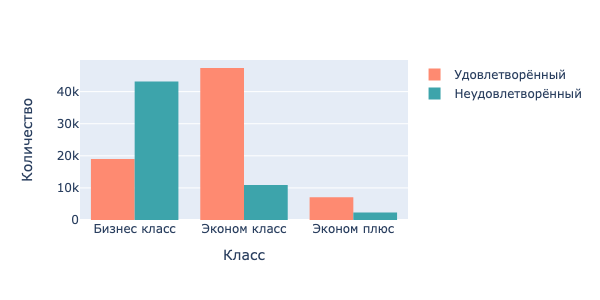

In [30]:
pio.renderers.default = "notebook_connected"
for col, title in zip(list_plot, xaxis_title):
    fig = px.histogram(data_frame = df
                       ,x = f'{col}'
                       , barmode="group",
                       width=600, height=300
                    , color = 'satisfaction',
                 color_discrete_sequence=['#FE8A71', '#3DA4AB', '#0E67A7']
             )
    fig.update_xaxes(title=f'{title}')
    fig.update_layout(
        yaxis_title="Количество",
        legend_title_text=None,
        title_x=0.5,
        xaxis_title=f'{title}'
    )
    fig.show("png")

* Пол: разница по половому признаку и удовлетворённости незначительная.
* Тип клиента: меньшее количество неудовлетворённых у тех, кто первый раз.
* Класс: самый довольный эконом-класс, бизнес-класс – более половины неудовлетворенных.  

In [31]:
list_plot2 = ['flightDistance', 'departureAndArrivalTimeConvenience', 'onBoardService', 'checkInService', \
              'onlineBoarding', 'seatComfort', 'legRoomService', 'cleanliness', 'foodAndDrink', \
              'inFlightWifiService']

xaxis_title2 = ['Дальность полёта', 'Удобство времени вылета и прибытия', 'Обслуживание на борту', 'Услуга регистрации заезда', \
               'Онлайн-посадка', 'Комфорт сидения', 'Обслуживание в номерах для ног', 'Чистоплотность', 'Еда и напитки', \
               'Услуга wi-fi в полёте']

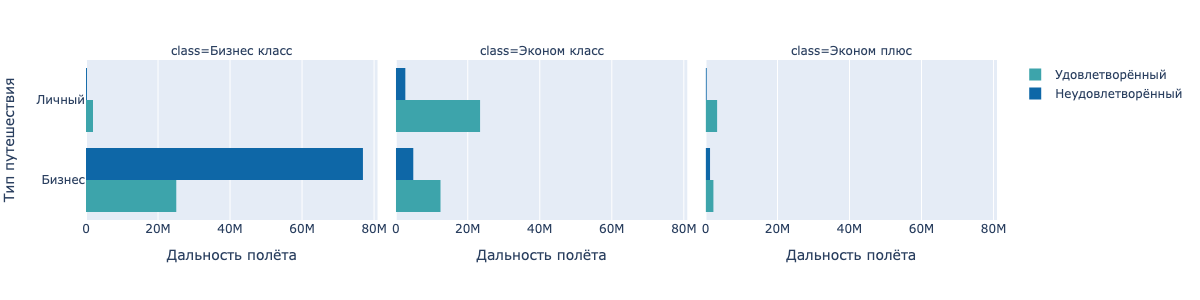

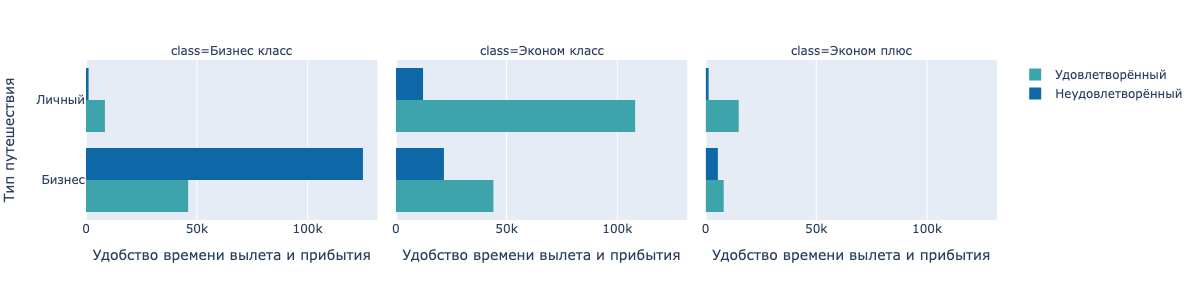

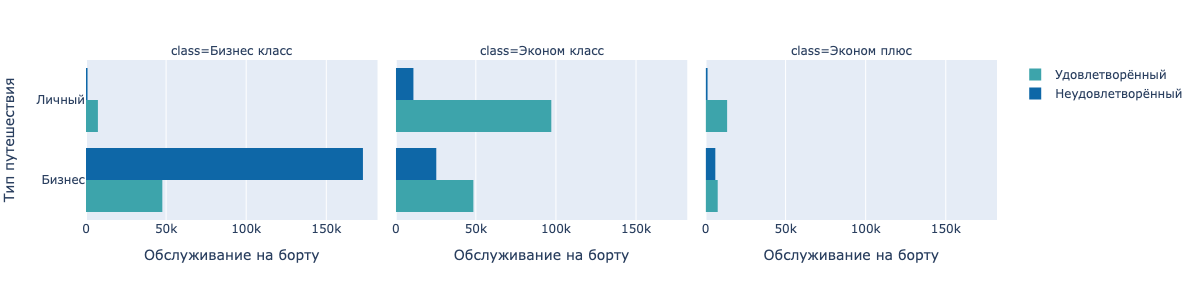

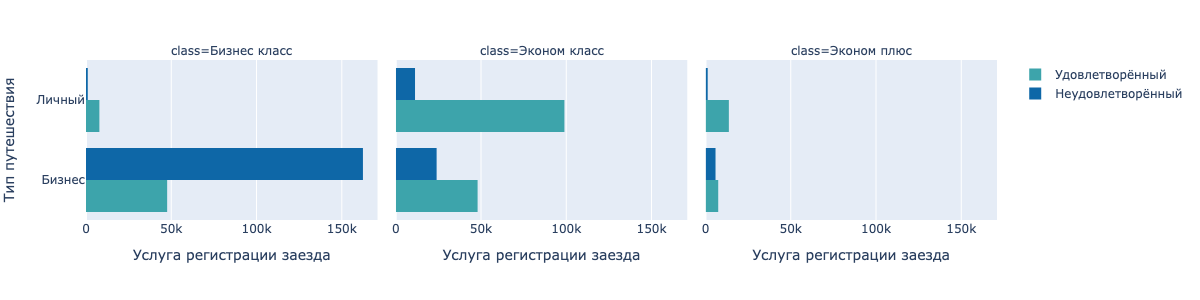

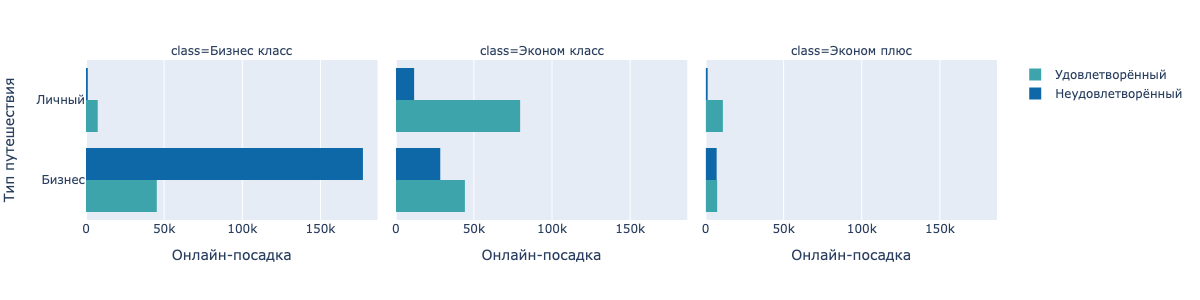

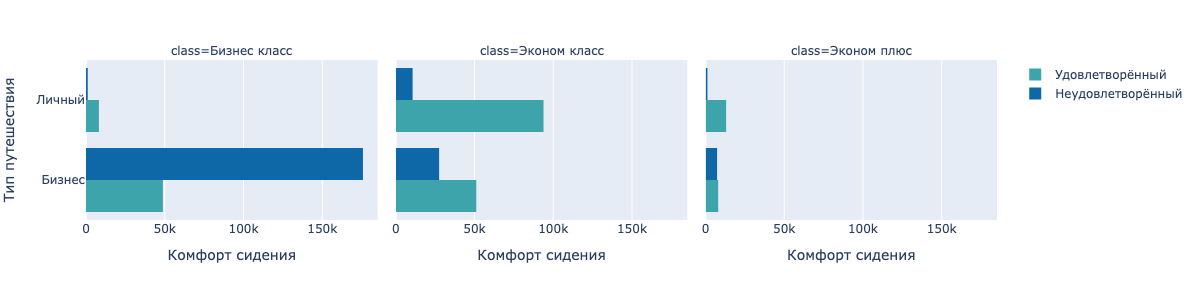

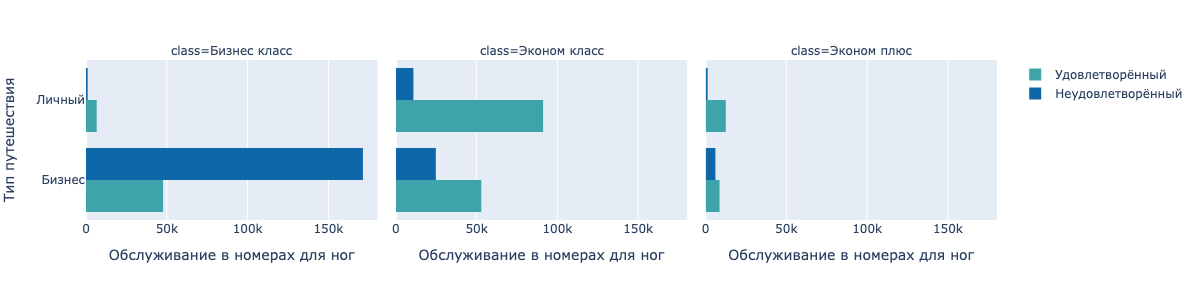

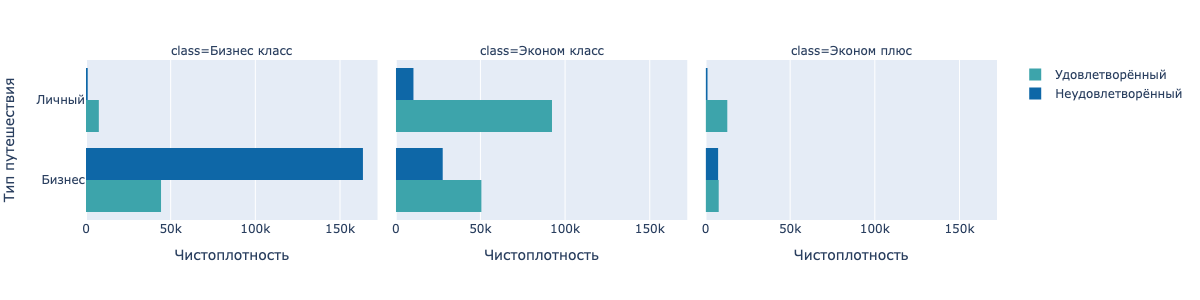

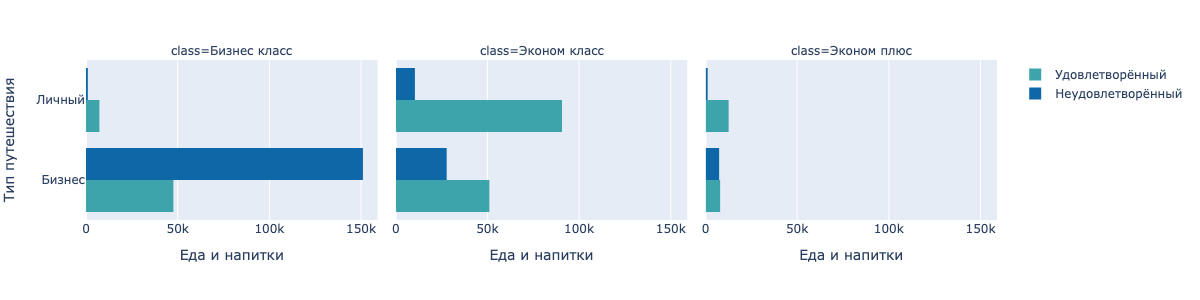

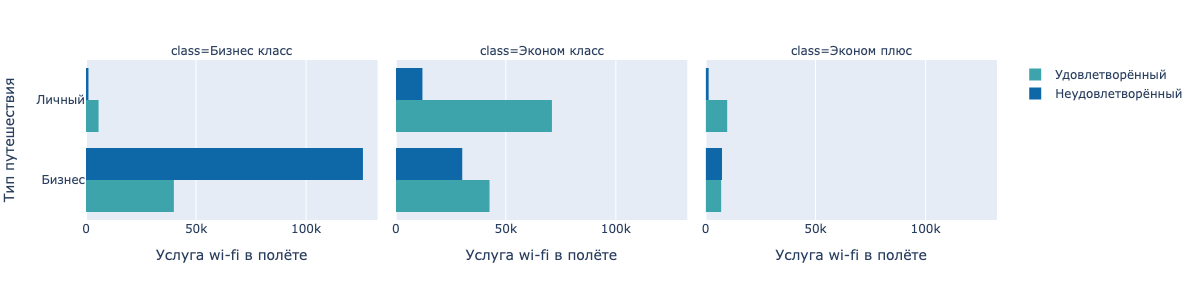

In [32]:
for col, title in zip(list_plot2, xaxis_title2):
    fig = px.histogram(data_frame = df
                       ,y = 'typeOfTravel', x = f'{col}'
                       ,facet_col = 'class', barmode="group",
                       width=1200, height=300
                    , color = 'satisfaction',
                 color_discrete_sequence=['#3DA4AB', '#0E67A7', '#FE8A71']
             )
    fig.update_xaxes(title=f'{title}')
    fig.update_layout(
        yaxis_title="Тип путешествия",
        title_x=0.5,
        xaxis_title=f'{title}',
        legend_title_text=None
    )
    fig.show("png")

In [33]:
display(pd.pivot_table(data=df, values='age', index='gender', columns='class', aggfunc='count'))

class,Бизнес класс,Эконом класс,Эконом плюс
gender,,,
Женщина,31263,29670,4966
Мужчина,30897,28639,4445


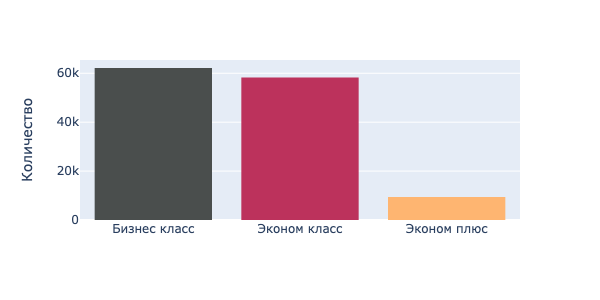

In [34]:
fig = px.histogram(df, x="class", color="class", width=600, height=300,
                   nbins=34, color_discrete_sequence=['#4A4E4D', '#BC325C', '#FEB571'])
fig.update_layout(
    yaxis_title="Количество",
    title_x=0.5,
    xaxis_title=None,
    showlegend=False
)
fig.show("png")

<u>Проведя предварительный анализ данных, очистив и преобразовав их, можно приступать к созданию прогнозной модели.<u>

#### Столбец с полом и номером ID клиента не имеют отношения к удовлетворенности, откажемся от этих столбцов для создания идеальной модели. 

In [35]:
df.satisfaction = df.satisfaction.replace({"Неудовлетворённый": 0, "Удовлетворённый": 1})
df['class'] = df['class'].replace({"Бизнес класс":2, "Эконом класс": 1, 'Эконом плюс': 0})
df.customerType = df.customerType.replace({'Первый раз': 0, 'Возвращаемый': 1}) 
df.typeOfTravel = df.typeOfTravel.replace({"Бизнес":0, "Личный": 1})

In [36]:
# Применяем функцию 
df.age = df.age.apply(age)

- категориальные данные преобразованы, избавимся от ненужных столбцов 

In [37]:
df.drop(['gender',"ID"],axis=1, inplace=True)

In [38]:
df.sample(4)

,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
32828,1,1,0,1,102,0,0.0,5,5,4,4,5,4,4,4,4,4,2,4,4,1,1
117025,2,1,0,1,304,82,60.0,2,2,4,3,2,2,3,2,4,4,2,2,2,2,1
18290,2,1,0,1,640,55,56.0,4,4,2,1,4,1,1,3,1,1,4,1,1,4,1
18471,1,1,0,1,305,0,0.0,2,2,2,5,2,2,5,4,5,5,5,5,5,5,0


#### Получим статистику и корреляцию данных 

In [39]:
df.describe()

,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,gateLocation,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling,satisfaction
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000
mean,1.600801,0.816908,0.309416,1.406136,1190.316392,14.713713,15.091129,3.057599,2.756876,3.306267,3.252633,2.976925,3.383023,3.441361,3.350878,3.286326,3.204774,3.642193,2.728696,3.358077,3.632114,0.565537
std,0.654171,0.386743,0.462255,0.621378,997.452477,38.071126,38.407410,1.526741,1.401740,1.266185,1.350719,1.278520,1.287099,1.319289,1.316252,1.313682,1.329933,1.176669,1.329340,1.334049,1.180025,0.495688
min,1.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000,1.000000,414.000000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,1.000000
75%,2.000000,1.000000,1.000000,2.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,5.000000,1.000000
max,3.000000,1.000000,1.000000,2.000000,4983.000000,1592.000000,1584.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [40]:
cor = df.corr(method = 'pearson')
cor = round(abs(cor.satisfaction), 2)
cor.sort_values(ascending=False)

satisfaction                          1.00
onlineBoarding                        0.50
typeOfTravel                          0.45
class                                 0.45
inflightEntertainment                 0.40
seatComfort                           0.35
onBoardService                        0.32
legRoomService                        0.31
cleanliness                           0.31
flightDistance                        0.30
inFlightWifiService                   0.28
baggageHandling                       0.25
inflightService                       0.24
checkInService                        0.24
foodAndDrink                          0.21
customerType                          0.19
easeOfOnlineBooking                   0.17
age                                   0.09
arrivalDelay                          0.06
departureAndArrivalTimeConvenience    0.05
departureDelay                        0.05
gateLocation                          0.00
Name: satisfaction, dtype: float64

#### Можно сделать вывод, что удовлетворённость клиентов не зависит от параметра "расположение ворот". Исключим его из набора данных для обучения прогнозной модели.


<a id="ref7"></a> 
### Создание модели прогноза

#### <u>Разделим набор данных<u>


In [41]:
X = df.drop(['satisfaction', "gateLocation"], axis=1)
y = df['satisfaction']

In [42]:
X.sample(3)

,age,customerType,typeOfTravel,class,flightDistance,departureDelay,arrivalDelay,departureAndArrivalTimeConvenience,easeOfOnlineBooking,checkInService,onlineBoarding,onBoardService,seatComfort,legRoomService,cleanliness,foodAndDrink,inflightService,inFlightWifiService,inflightEntertainment,baggageHandling
74089,2,1,0,2,3046,0,0.0,5,5,4,5,4,5,4,5,3,4,5,4,4
10732,2,1,0,1,224,53,42.0,3,3,1,2,3,2,4,2,1,3,4,3,3
20724,1,1,1,1,765,11,0.0,5,3,3,3,5,2,2,2,2,4,3,2,5


In [43]:
y.sample(3)

95954     0
103674    1
109687    1
Name: satisfaction, dtype: int64

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [45]:
print(f'''Размеры выборок 
обучающая X,y - {X_train.shape[0]} строк
тестовая X,y - {X_test.shape[0]} строк''')

Размеры выборок 
обучающая X,y - 97410 строк
тестовая X,y - 32470 строк


#### Используем следующие методы ML:
* Логистическая регрессия
* Метод k-ближайших соседей
* Алгоритм случайного леса
* Дерево решений
* Наивный Байесовский классификатор
* AdaBoost

#### Далее:
* Обучим модель
* Примерим модель
* Получим прогноз с помощью теста 
* Оценим точность 
* Матрица путаницы   
* ROC-кривая
* Время, затраченное каждый моделью


In [46]:
df_class_accuracy = pd.DataFrame(columns=['Метод', 'Точность', 'Кривая_ошибок', 'Время'])

### <u>Логистическая регрессия :<u>

Точность прогноза = 0.801632275947028
AUC ROC - Площадь под кривой ошибок = 0.7998296467681514
Затраченное время = 2.9958038330078125
              precision    recall  f1-score   support

           0    0.76123   0.78673   0.77377     14001
           1    0.83411   0.81293   0.82338     18469

    accuracy                        0.80163     32470
   macro avg    0.79767   0.79983   0.79858     32470
weighted avg    0.80268   0.80163   0.80199     32470



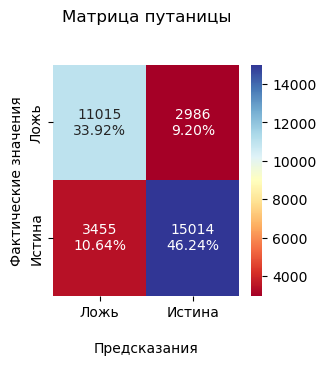

In [47]:
model_LR = LogisticRegression()
model_LR, accuracy_LR, roc_auc_LR, time_LR = model_create(model_LR, X_train, y_train, X_test, y_test)

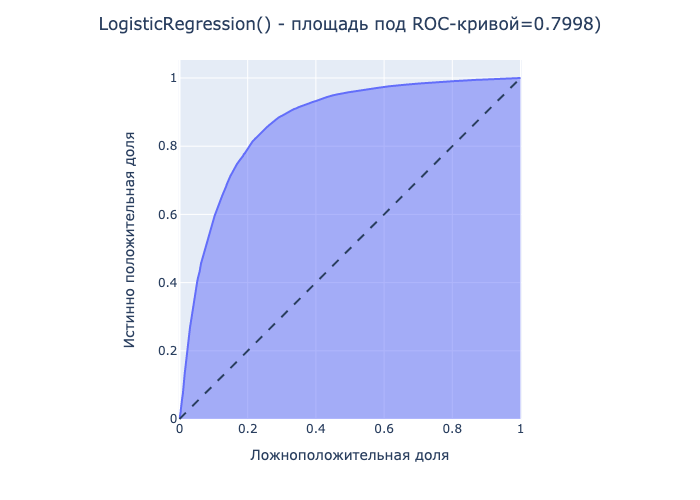

In [48]:
roc_auc(model_LR,  roc_auc_LR, X_test, y_test)

In [49]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['Logistic Regression', accuracy_LR, roc_auc_LR, time_LR]

### <u>Дерево решений:<u>

Точность прогноза = 0.9424699722821066
AUC ROC - Площадь под кривой ошибок = 0.9414201012977311
Затраченное время = 0.5502159595489502
              precision    recall  f1-score   support

           0    0.93286   0.93379   0.93332     14001
           1    0.94977   0.94905   0.94941     18469

    accuracy                        0.94247     32470
   macro avg    0.94131   0.94142   0.94137     32470
weighted avg    0.94248   0.94247   0.94247     32470



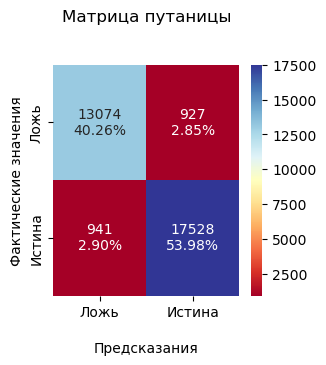

In [50]:
model_DC = DecisionTreeClassifier()
model_DC, accuracy_DC, roc_auc_DC, time_DC = model_create(model_DC, X_train, y_train, X_test, y_test)

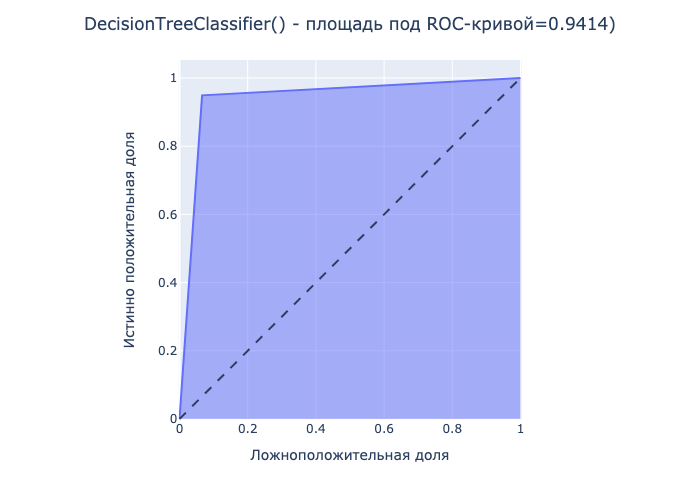

In [51]:
roc_auc(model_DC, roc_auc_DC, X_test, y_test)

In [52]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['DecisionTreeClassifier', accuracy_DC, roc_auc_DC, time_DC]

### <u>Случайный лес:<u>

Точность прогноза = 0.9607329842931938
AUC ROC - Площадь под кривой ошибок = 0.9580355868163142
Затраченное время = 9.772792100906372
              precision    recall  f1-score   support

           0    0.96952   0.93843   0.95373     14001
           1    0.95443   0.97764   0.96590     18469

    accuracy                        0.96073     32470
   macro avg    0.96198   0.95804   0.95981     32470
weighted avg    0.96094   0.96073   0.96065     32470



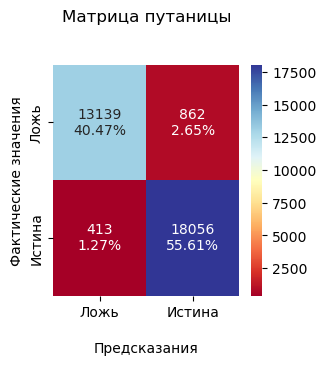

In [53]:
model_RF = RandomForestClassifier()
model_RF, accuracy_RF, roc_auc_RF, time_RF = model_create(model_RF, X_train, y_train, X_test, y_test)

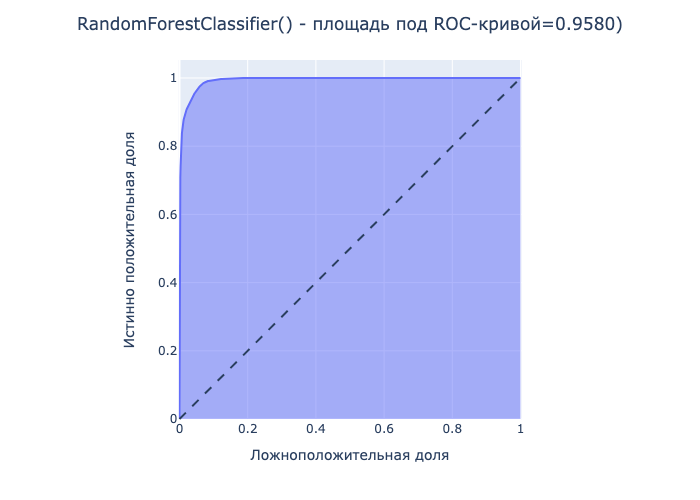

In [54]:
roc_auc(model_RF, roc_auc_RF, X_test, y_test)

In [55]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['Random Forest', accuracy_RF, roc_auc_RF, time_RF]

### <u>Наивный байесовский классификатор:<u>

Точность прогноза = 0.8665537419156144
AUC ROC - Площадь под кривой ошибок = 0.8606822805742443
Затраченное время = 0.2440319061279297
              precision    recall  f1-score   support

           0    0.86516   0.81801   0.84093     14001
           1    0.86751   0.90335   0.88507     18469

    accuracy                        0.86655     32470
   macro avg    0.86634   0.86068   0.86300     32470
weighted avg    0.86650   0.86655   0.86604     32470



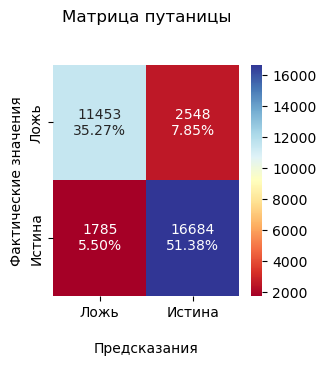

In [56]:
model_NB = GaussianNB() 
model_NB, accuracy_NB, roc_auc_NB, time_NB = model_create(model_NB, X_train, y_train, X_test, y_test)

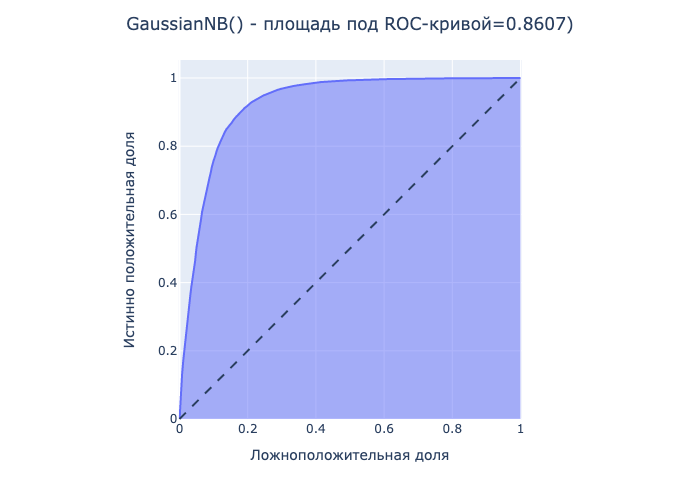

In [57]:
roc_auc(model_NB, roc_auc_NB, X_test, y_test)

In [58]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['Naive Bayes Classifier', accuracy_NB, roc_auc_NB, time_NB]

### <u>K-ближайшие соседи :<u>

Точность прогноза = 0.7751154912226671
AUC ROC - Площадь под кривой ошибок = 0.7647276140161381
Затраченное время = 10.358874082565308
              precision    recall  f1-score   support

           0    0.76581   0.68924   0.72551     14001
           1    0.78102   0.84022   0.80954     18469

    accuracy                        0.77512     32470
   macro avg    0.77341   0.76473   0.76752     32470
weighted avg    0.77446   0.77512   0.77330     32470



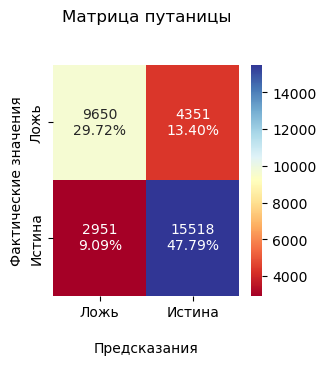

In [59]:
model_KNN = KNeighborsClassifier(n_neighbors=22)
model_KNN, accuracy_KNN, roc_auc_KNN, time_KNN = model_create(model_KNN, X_train, y_train, X_test, y_test)

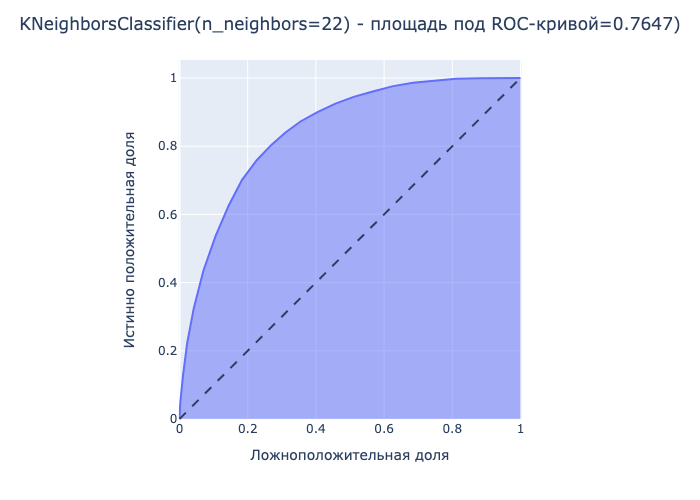

In [60]:
roc_auc(model_KNN, roc_auc_KNN, X_test, y_test)

In [61]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['K-Nearest Neighbors', accuracy_KNN, roc_auc_KNN, time_KNN]

### <u>Классификатор AdaBoost:<u>

Точность прогноза = 0.9276562981213428
AUC ROC - Площадь под кривой ошибок = 0.9251671665555444
Затраченное время = 4.049418926239014
              precision    recall  f1-score   support

           0    0.92377   0.90708   0.91535     14001
           1    0.93051   0.94326   0.93684     18469

    accuracy                        0.92766     32470
   macro avg    0.92714   0.92517   0.92609     32470
weighted avg    0.92760   0.92766   0.92757     32470



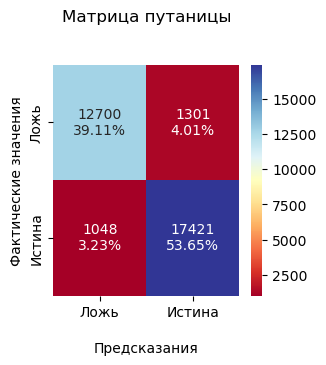

In [62]:
model_AB = AdaBoostClassifier(n_estimators=50,learning_rate=1)
model_AB, accuracy_AB, roc_auc_AB, time_AB = model_create(model_AB, X_train, y_train, X_test, y_test)

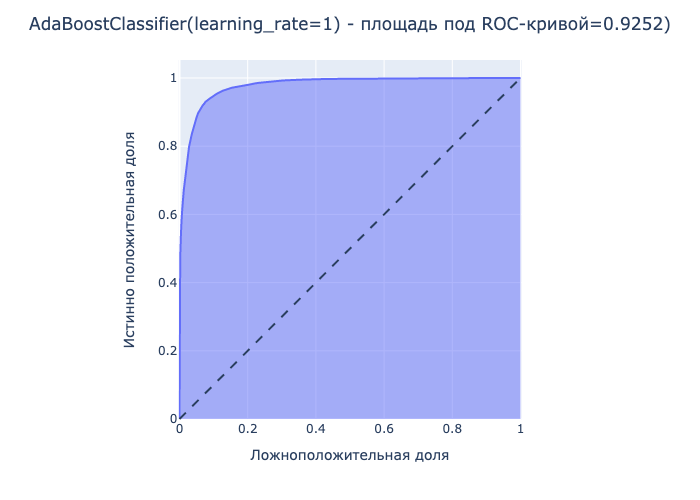

In [63]:
roc_auc(model_AB, roc_auc_AB, X_test, y_test)

In [64]:
df_class_accuracy.loc[len(df_class_accuracy)] = ['AdaBoostClassifier', accuracy_AB, roc_auc_AB, time_AB]

#### Сравним модели

- Структурируем данные по каждой прогнозной модели в виде таблицы, отсортируем и отобразим. 

- Оценим модели с точки зрения кривой ошибок и общего времени, затраченного на выполнение.

In [65]:
df_class_accuracy.sort_values(by=['Время'], ascending=False)

,Метод,Точность,Кривая_ошибок,Время
4,K-Nearest Neighbors,0.775115,0.764728,10.358874
2,Random Forest,0.960733,0.958036,9.772792
5,AdaBoostClassifier,0.927656,0.925167,4.049419
0,Logistic Regression,0.801632,0.799830,2.995804
1,DecisionTreeClassifier,0.942470,0.941420,0.550216
3,Naive Bayes Classifier,0.866554,0.860682,0.244032


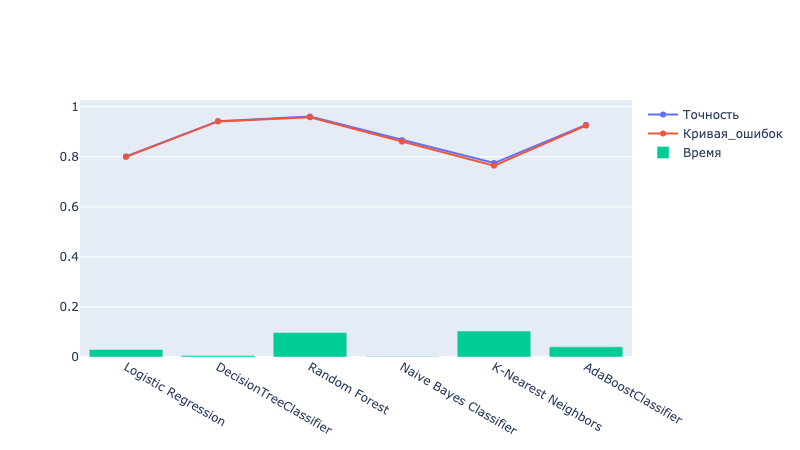

In [66]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df_class_accuracy['Метод'],
        y=df_class_accuracy['Точность'],
        mode="lines+markers+text",
        name='Точность'
    ))
fig.add_trace(
    go.Scatter(
        x=df_class_accuracy['Метод'],
        y=df_class_accuracy['Кривая_ошибок'],
        mode="lines+markers+text",
        name='Кривая_ошибок'
    ))

fig.add_trace(
    go.Bar(
        x=df_class_accuracy['Метод'],
        y=df_class_accuracy['Время'] / 100,
        name='Время'
    ))              
gitly.show(fig)

### Выводы:
* Точность & ROC-AUC:  
Max - **Случайный лес**  
Min - **K-ближайших соседей**  
<br>

* По затраченному времени на прогноз:   
max - **K-ближайших соседей**  
min - **Наивный байесовский классификатор**

#### Выберем лучшую модель по следующим параметрам:
* Максимальные ROC_AUC, точность 
* Минимальное время

#### Модель "Дерево решений" является лучшим из применённых алгоритмов для прогнозирования:
- Точность - 94% 
- Время выполнения - 0.5 s